Other posts in this series:  

[A Journey Through Fastbook (AJTFB) - Chapter 1](2020-11-06-ajtfb-chapter-1.ipynb)  
[A Journey Through Fastbook (AJTFB) - Chapter 2](2020-11-16-ajtfb-chapter-2.ipynb)  
[A Journey Through Fastbook (AJTFB) - Chapter 3](2020-11-22-ajtfb-chapter-3.ipynb)  
[A Journey Through Fastbook (AJTFB) - Chapter 4](2021-05-23-ajtfb-chapter-4.ipynb)  
[A Journey Through Fastbook (AJTFB) - Chapter 5](2021-06-03-ajtfb-chapter-5.ipynb)  
[A Journey Through Fastbook (AJTFB) - Chapter 6b](2022-02-09-ajtfb-chapter-6-regression.ipynb)  
[A Journey Through Fastbook (AJTFB) - Chapter 7](2022-03-28-ajtfb-chapter-7.ipynb)  
[A Journey Through Fastbook (AJTFB) - Chapter 8](2022-03-31-ajtfb-chapter-8.ipynb)    
[A Journey Through Fastbook (AJTFB) - Chapter 9](2022-04-25-ajtfb-chapter-9.ipynb)    

In [1]:
#| include: false
!pip install fastai>=2.3 --upgrade

import fastai
from fastai.vision.all import *
print(fastai.__version__ )

2.5.6


In [2]:
#| include: false
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

## Multiclass vs Multi-label classification (again)...

Last post we saw that **multiclass classification** is all about predicting a SINGLE CLASS an object belongs to from a list of two or more classes. It's the go to task if we're confident that every image our model sees is going to be one of these classes. **Cross-entropy loss** is our go to loss function as it wants to confidently pick one thing.

**Multi-label classification** involves predicting MULTIPLE CLASSES to which an object belongs; it can belong to one, some, all, or even none of those classes. For example, you may be looking at satellite photos from which you need to predict the different kinds of terrain (your classes) each contains.

:::{.callout-important}

Use the multi-label classification approach in your "multiclassification problems" where you want your model to be able to result in None (which is probably a more common real world use case)

:::

## Defining your DataBlock

Again, the `DataBlock` is a blueprint for everything required to turn your raw data (images and labels) into something that can be fed through a neural network (DataLoaders with a numerical representation of both your images and labels).  Below is the one presented in this chapter.



In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

Instead of working with the filesystem structure to get our images and define our labels, in this example we use a .csv file that we can explore and manipulate further via a pandas **DataFrame**.

:::{.callout-important}

DataFrames are one of those things you're going to want to get comfortable using. Personally, I love using them if for nothing else, for how ubiquitous they are.  You can create them from .csv files, excel files, dictionaries, from a sql database, and so forth. This makes them a fabulous datasource around which to build your DataBlocks!

:::

Here are some of my favorite pandas resources:
1. https://chrisalbon.com/
2. https://pandas.pydata.org/docs/ (yah, the docs are really good!)

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [5]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                   get_x=get_x, 
                   get_y=get_y,
                   splitter=splitter, # or could just have used ColSplitter()   
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))

**Let's break down our blueprint**!

1. Define the data types for our inputs and targets via the `blocks` argument.

  This is defined as a tuple, where we tell our `DataBlock` that the imputs are images and our targets are multiple potential categories. Above we can see that these labels are space delimited in the "labels" column.  The later essentially returns a one-hot encoded list of possible labels, with a 0 indicating that the label wasn't found for the item and a 1 indicating otherwise (see the `DataBlock.summary` results below).

2. Define how we're going to get our images via `get_x`.

  As we'll be passing in a Dataframe as the raw data source, we don't need to define a `get_items` to pull the raw data.  We do however, need to instruct the DataBlock as to how to find the images, which we do via the `get_x` method.  That method will get one row of DataFrame (`r`) at a time.

3. Define how, from the raw data, we're going to create our labels via `get_y`.

  As already mentioned, the classes are in the "labels" column and delimited by a space, and so, we return a list of labels splitting on ' '. Easy peasy.

4. Define how we're going to create our [validation dataset](https://www.fast.ai/2017/11/13/validation-sets/) via `splitter`

  Here we define a custom splitter mostly to just show you how to do it.  It has to return at least a tuple of train, validation data. We could have just used `ColSplitter` ([see it in the docs here](https://docs.fast.ai/data.transforms.html#ColSplitter))

5. Define things we want to do for each item via `item_tfms`

  `item_tfms` are transforms, or things we want to do, to each input individually!  Above we only have one which says, "Randomly crop the image to be 128x128 that captures at least 35% of the image each time you grab an image".  See here for more info on [`RandomResizedCrop`](https://docs.fast.ai/vision.augment.html#RandomResizedCrop)

6. Define things we want to do for each mini-batch of items via `batch_tfms`

  None here, but remember that these are transforms you want applied to a mini-batch of images on the GPU at the same time.

:::{.callout-important}

Do not use lambda functions for defining your DataBlock methods! They can't be serialized and so you're lucky to get some errors when you try to save/export your DataLoaders and/or Learner

:::

:::{.callout-important}

Verify your `DataBlock` works as expected, or else troubleshoot it, by running `DataBlock.summary(data)`

:::

In [6]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /root/.fastai/data/pascal_2007/train/00001

Now we can create our `DataLoaders` and take a look at our x's and y's, our images and their labels (multiple labeled images have their labels separated by semi-colon)

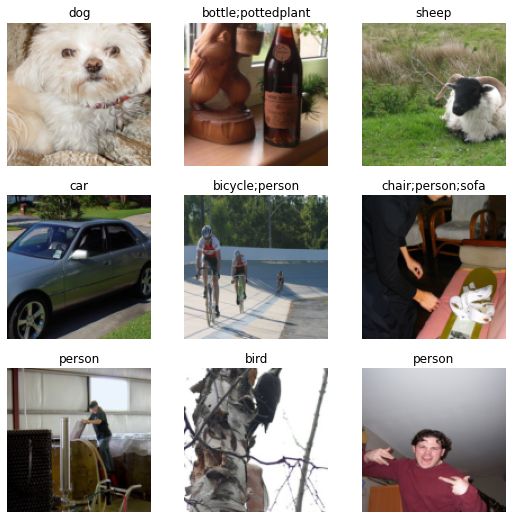

In [7]:
dls = dblock.dataloaders(df)
dls.show_batch()

To get a feel for what our `item_tfms` (and `batch_tfms` if we had them) are doing, we can `show_batch` using a single image as we do below.

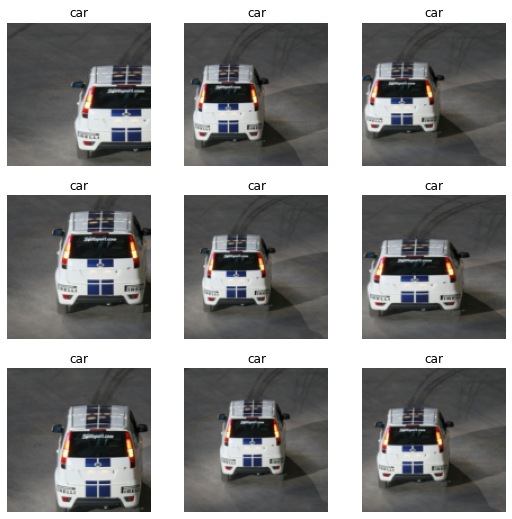

In [8]:
dls.show_batch(unique=True)

The combination of what we're doing in the `item_tfms` and `batch_tfms` is known as **presizing**.  

"Presizing is a particular way to do image augmentation that is designed to minimize data destruction while maintaining good performance."  After resizing all the images to a larger dimension that we will train on, we perform all our core augmentations on the GPU.  This results in both faster and less destructive transformations of the data.

:::{.callout-important}

See pp190-191 for how these augmentations are applied to the training and validation set!

:::

## Train a model

:::{.callout-important}

"Once you think your data looks right, we generally recommend the next step should be using it to train a simple model" See bottom of p193 for why.

:::

### Define your loss function

To train a model we need a good loss function that will allow us to optimize the parameters of our model. For multi-label classification tasks where we want to predict a single class/label, to go to is **binary cross-entropy loss**

:::{.callout-important}

Cross-entropy loss is the U.S. Marine of loss functions ... "the few, the proud, the one hot encoded"

:::

**Why can't we just use cross-entropy loss?**

Because "the softmax function *really* wants to pick one class" whereas here want it to pick multiple or even none. 

"**softmax** ... requires that all predictions sum to 1, and tends to push one activation to be much larger than the others (because of the use of `exp`) ... we may want the sum to be less than 1, if we don't think *any* of the categories appear in an image."  

"**nll_loss** ... returns the value of just one activation: the single activation corresponding with the single label for an item [which] doesn't make sense when we have multiple labels"

In [9]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

:::{.callout-important}

Run a batch through model to see/verify your batches and final activations look right.

:::

In [12]:
xb, yb = to_cpu(dls.train.one_batch())
res = learn.model(xb)
xb.shape, yb[0], res.shape, res[0]

(torch.Size([64, 3, 128, 128]),
 TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
         0., 0.]),
 torch.Size([64, 20]),
 TensorBase([ 1.4774, -2.1223,  4.1004,  1.5169, -0.5184,  0.1914, -1.0933, -1.4870,
         -1.4855, -0.9137, -2.1899,  2.5738,  2.6155, -1.8979,  0.9340,  1.2691,
         -0.2225,  0.4355, -4.2410, -2.5808], grad_fn=<AliasBackward0>))

So now we need a loss function that will scale those activations to be between 1 and 0 and then compare each activation with the value (0 or 1) in each target column.

In [13]:
def bce(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, inputs, 1-inputs).log().mean()

print(bce(res, yb))

TensorMultiCategory(1.0537, grad_fn=<AliasBackward0>)


So breaking the above down, line by line, for a single input/targets ...


In [14]:
inps = res.sigmoid()
print(f'1. {inps[0]}')
print(f'2. {yb[0]}')
print(f'3. {torch.where(yb==1, inps, 1-inps)[0]}')
print(f'4. {torch.where(yb==1, inps, 1-inps)[0].log()}')
print(f'5. {torch.where(yb==1, inps, 1-inps)[0].log().mean()}')
print(f'6. {-torch.where(yb==1, inps, 1-inps)[0].log().mean()}')

1. TensorBase([0.8142, 0.1070, 0.9837, 0.8201, 0.3732, 0.5477, 0.2510, 0.1844, 0.1846,
        0.2862, 0.1007, 0.9292, 0.9319, 0.1303, 0.7179, 0.7806, 0.4446, 0.6072,
        0.0142, 0.0704], grad_fn=<AliasBackward0>)
2. TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0.])
3. TensorMultiCategory([0.1858, 0.8930, 0.0163, 0.1799, 0.3732, 0.4523, 0.7490, 0.8156, 0.8154,
        0.7138, 0.8993, 0.0708, 0.0681, 0.8697, 0.7179, 0.7806, 0.5554, 0.3928,
        0.9858, 0.9296], grad_fn=<AliasBackward0>)
4. TensorMultiCategory([-1.6830, -0.1131, -4.1168, -1.7153, -0.9856, -0.7934, -0.2890, -0.2038,
        -0.2041, -0.3372, -0.1061, -2.6473, -2.6861, -0.1397, -0.3314, -0.2477,
        -0.5881, -0.9344, -0.0143, -0.0730], grad_fn=<AliasBackward0>)
5. -0.9104629755020142
6. 0.9104629755020142


**... what is binary cross-entropy loss doing?**

Scale all activations to be between 0 and 1 using the `sigmoid` function (1). The resulting activations tell us, for each potential label, how confident the model is that the value is a "1".

Build a tensor with a value for each target (2); if the target = 1 then use the corresponding scaled value above ... if the target = 0, then use 1 minus this value (3). *Notice how confident correct predictions will be very large, while confident incorrect predictions will be very small.* We can think of this value as telling us how right the model was in predicting each label.

Take the `log` (4) which will will turn correct and more confident predictions (those closer to 1) to a value closer to zero, and wrong and more confident prediction to a value closer to 0.  This exactly what we want since the better the model, the smaller the lost, and the `log(1) = 0` where as the `log(0)` approaches negative infinity! See the chart below.

Lastly, because the loss has to be a single value, we mean the losses for each label (5), and then turn it into a positive (6).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  This is separate from the ipykernel package so we can avoid doing imports until


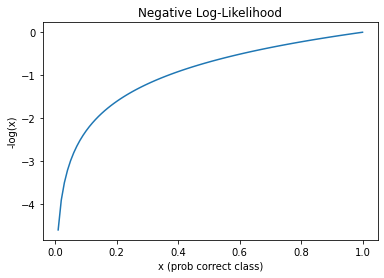

In [15]:
plot_function(torch.log, 'x (prob correct class)', '-log(x)', title='Negative Log-Likelihood', min=0, max=1)

:::{.callout-important}

Review BCE and Cross Entropy Loss until you can explain it to your significant other :).  They are by and far the most common loss functions you'll come across and many of the problems you encounter in training your models will be because you're using the wrong one.

:::


Fortunately, PyTorch has a function and module we can use:

In [16]:
# functional form
loss = F.binary_cross_entropy_with_logits(res, yb)
print(loss)

# modular form (most commonly used)
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(res, yb)
print(loss)

# and for shits and giggles
print(bce(res, yb))

TensorMultiCategory(1.0537, grad_fn=<AliasBackward0>)
TensorMultiCategory(1.0537, grad_fn=<AliasBackward0>)
TensorMultiCategory(1.0537, grad_fn=<AliasBackward0>)


:::{.callout-important}

"Normally, for one-hot-encoded targets, you'll want `F.binary_cross_entropy_with_logits` (or `nn.BCEWithLogitsLoss`), which do both sigmoid and binary cross entropy in a single function.

:::

If the final activations already have the sigmoid applied to it, then you'd use `F.binary_cross_entropy` (or `nn.BCELoss`).

### Define Your Metrics and Thresholds

One of the trickier bits with multilabel tasks, is selecting at what threshold (probability) do we want to consider a label 1 or 0.  Using accuracy as our metric, we can play around with different values ...

In [17]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.939569,0.704923,0.230299,00:41
1,0.820619,0.558957,0.290279,00:38
2,0.602579,0.195408,0.835618,00:38
3,0.358107,0.122511,0.945438,00:38


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.131727,0.116799,0.945359,00:41
1,0.116440,0.109859,0.949861,00:40
2,0.097460,0.103571,0.954841,00:40


:::{.callout-important}

We didn't have to specify BCE as our loss function above because fastai was smart enough to figure it out from the dataset. This isn't always the case, in particular when you start building your own or use 3rd party models for training. So Trainer beware!

:::

In [18]:
learn.metrics = partial(accuracy_multi, thresh=0.2)
print(learn.validate())

learn.metrics = partial(accuracy_multi, thresh=0.9)
print(learn.validate())

learn.metrics = partial(accuracy_multi, thresh=0.75)
print(learn.validate())

[0.10357054322957993, 0.9548406004905701]


[0.10357054322957993, 0.9559162855148315]


[0.10357054322957993, 0.9615935683250427]


:::{.callout-important}

"This is much faster if we grab the predictions just once .... Note that by default `get_preds` applies the output activat function (sigmoid, in this case) for us, so we'll need to tell `accuracy_multi` to not apply it"

:::

In [19]:
preds, targs = learn.get_preds()

In [20]:
print(accuracy_multi(preds, targs, thresh=0.9, sigmoid=False))

TensorBase(0.9559)


:::{.callout-important}

Find the best threshold by testing over a range of potential thresholds!

:::

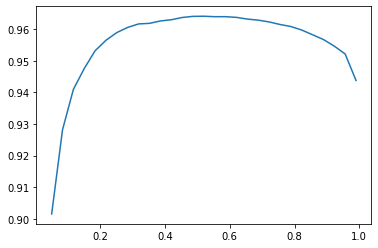

In [21]:
thresholds = torch.linspace(0.05, 0.99, 29)
accs = [accuracy_multi(preds, targs, thresh=th, sigmoid=False) for th in thresholds]
plt.plot(thresholds, accs)

In [22]:
print(accuracy_multi(preds, targs, thresh=0.55, sigmoid=False))

TensorBase(0.9640)


:::{.callout-important}

"... using the validation set to pick a hyperparameter (the threshold), which is the purpose of the validation set" is perfectly fine here. "As you see in the plot, changing the threshold in this case results in a smooth curve, so we're clearly not picking an inappropriate outlier".

:::


See p.231 for more discussion on this.

## Summary

You now know how to train both multi-label and muticlass vistion problems, when to use one or another, and what loss function to choose for each. You should consider treating multiclass problems where the predicted class should be "None" as a multi-label problem, especially if this is going to be used in the real-world and not just against some prefabbed dataset.

Also, we're using accuracy as our metric to optimize the threshold in the example above, *but* you can use any metric (or combination of metrics you want).  For example, a common issue with multi-label tasks is unbalanced datasets where one or more targets are ill represented in number.  In that case, it may be more productive to use something like F1 or Recall.


## Resources

1. https://book.fast.ai - The book's website; it's updated regularly with new content and recommendations from everything to GPUs to use, how to run things locally and on the cloud, etc...
2. To learn more about pandas check the [pandas documentation](https://pandas.pydata.org/docs/) and [chrisalbon.com](https://chrisalbon.com/).